In [ ]:
# STEP 0: Environment Setup

import pandas as pd
import numpy as np

# Load dataset
path = "/content/drive/MyDrive/credit_risk_dataset.csv"
df = pd.read_csv(path)

# Basic inspection
print("Shape:", df.shape)
df.head()


Shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
df_inputs.columns


Index(['age_group', 'employment_type', 'months_employed', 'city_tier',
       'monthly_income', 'monthly_expenses', 'savings_rate',
       'expense_volatility', 'digital_txn_freq', 'past_emi_delays',
       'loan_amount', 'loan_tenure_months', 'loan_purpose', 'expected_emi',
       'income_to_emi', 'cashflow_surplus', 'savings_buffer_score',
       'behavior_consistency', 'repayment_reliability', 'income_to_emi_norm',
       'cashflow_surplus_norm', 'savings_buffer_score_norm',
       'behavior_consistency_norm', 'repayment_reliability_norm'],
      dtype='object')

In [ ]:
# STEP 1A: User Profile Inputs

df_inputs = pd.DataFrame()

# Age buckets
df_inputs["age_group"] = pd.cut(
    df["person_age"],
    bins=[17, 25, 35, 50, 100],
    labels=["18-25", "26-35", "36-50", "50+"]
)

# Employment type proxy (based on income stability assumption)
df_inputs["employment_type"] = np.where(
    df["person_income"] > 30000, "Salaried", "Self-employed"
)

# Employment length
df_inputs["months_employed"] = df["person_emp_length"].fillna(0)

# FIXED City Tier Proxy (Income-based)

df_inputs["city_tier"] = pd.cut(
    df["person_income"],
    bins=[0, 20000, 50000, 100000, np.inf],
    labels=["Tier 3", "Tier 2", "Tier 1", "Tier 1+"],
    include_lowest=True
)


df_inputs.head()


,age_group,employment_type,months_employed,city_tier
0,18-25,Salaried,123.0,Tier 1
1,18-25,Self-employed,5.0,Tier 3
2,18-25,Self-employed,1.0,Tier 3
3,18-25,Salaried,4.0,Tier 1
4,18-25,Salaried,8.0,Tier 1


In [ ]:
df_inputs["city_tier"].value_counts(dropna=False)


,count
city_tier,
Tier 1,14292
Tier 2,12910
Tier 1+,4207
Tier 3,1172


In [ ]:
# STEP 1B: Financial Behavior Inputs (Validated & Safe)

# 1. Monthly income (ensure non-zero)
df_inputs["monthly_income"] = (df["person_income"] / 12).clip(lower=1)

# 2. Monthly expenses (cap at income)
df_inputs["monthly_expenses"] = (
    df_inputs["monthly_income"] * df["loan_percent_income"]
).clip(upper=df_inputs["monthly_income"])

# 3. Savings rate (bounded 0–1)
df_inputs["savings_rate"] = (
    (df_inputs["monthly_income"] - df_inputs["monthly_expenses"])
    / df_inputs["monthly_income"]
).clip(0, 1)

# 4. Expense volatility (safe binning)
df_inputs["expense_volatility"] = pd.cut(
    df["loan_percent_income"].clip(0, 1),
    bins=[0, 0.3, 0.6, 1],
    labels=["Low", "Medium", "High"],
    include_lowest=True
)

# 5. Digital transaction frequency (cap extreme values)
df_inputs["digital_txn_freq"] = df["cb_person_cred_hist_length"].clip(0, 20)

# 6. Past EMI delays (binary)
df_inputs["past_emi_delays"] = (
    df["cb_person_default_on_file"]
    .map({"Y": 1, "N": 0})
    .fillna(0)
    .astype(int)
)

df_inputs.head()


,age_group,employment_type,months_employed,city_tier,monthly_income,monthly_expenses,savings_rate,expense_volatility,digital_txn_freq,past_emi_delays
0,18-25,Salaried,123.0,Tier 1,4916.666667,2900.833333,0.41,Medium,3,1
1,18-25,Self-employed,5.0,Tier 3,800.000000,80.000000,0.90,Low,2,0
2,18-25,Self-employed,1.0,Tier 3,800.000000,456.000000,0.43,Medium,3,0
3,18-25,Salaried,4.0,Tier 1,5458.333333,2892.916667,0.47,Medium,2,0
4,18-25,Salaried,8.0,Tier 1,4533.333333,2493.333333,0.45,Medium,4,1


In [ ]:
df_inputs.describe(include="all")


,age_group,employment_type,months_employed,city_tier,monthly_income,monthly_expenses,savings_rate,expense_volatility,digital_txn_freq,past_emi_delays
count,32576,32581,32581.000000,32581,32581.000000,32581.000000,32581.000000,32581,32581.000000,32581.000000
unique,4,2,NaN,4,NaN,NaN,NaN,3,NaN,NaN
top,18-25,Salaried,NaN,Tier 1,NaN,NaN,NaN,Low,NaN,NaN
freq,15352,28065,NaN,14292,NaN,NaN,NaN,28747,NaN,NaN
mean,NaN,NaN,4.658114,NaN,5506.237372,796.830236,0.829797,NaN,5.768853,0.176330
std,NaN,NaN,4.159669,NaN,5165.259931,523.805242,0.106782,NaN,3.897923,0.381106
min,NaN,NaN,0.000000,NaN,333.333333,0.000000,0.170000,NaN,2.000000,0.000000
25%,NaN,NaN,2.000000,NaN,3208.333333,412.500000,0.770000,NaN,3.000000,0.000000
50%,NaN,NaN,4.000000,NaN,4583.333333,671.666667,0.850000,NaN,4.000000,0.000000
75%,NaN,NaN,7.000000,NaN,6600.000000,1027.794167,0.910000,NaN,8.000000,0.000000


In [ ]:
#Loan Request Inputs

df_inputs["loan_amount"] = df["loan_amnt"]
df_inputs["loan_tenure_months"] = 12  # assumed standard tenure
df_inputs["loan_purpose"] = df["loan_intent"]

df_inputs.head()


,age_group,employment_type,months_employed,city_tier,monthly_income,monthly_expenses,savings_rate,expense_volatility,digital_txn_freq,past_emi_delays,loan_amount,loan_tenure_months,loan_purpose
0,18-25,Salaried,123.0,Tier 1,4916.666667,2900.833333,0.41,Medium,3,1,35000,12,PERSONAL
1,18-25,Self-employed,5.0,Tier 3,800.000000,80.000000,0.90,Low,2,0,1000,12,EDUCATION
2,18-25,Self-employed,1.0,Tier 3,800.000000,456.000000,0.43,Medium,3,0,5500,12,MEDICAL
3,18-25,Salaried,4.0,Tier 1,5458.333333,2892.916667,0.47,Medium,2,0,35000,12,MEDICAL
4,18-25,Salaried,8.0,Tier 1,4533.333333,2493.333333,0.45,Medium,4,1,35000,12,MEDICAL


In [ ]:
df_inputs["expected_emi"] = df_inputs["loan_amount"] / df_inputs["loan_tenure_months"]


**Expected EMI**

In [ ]:
df_inputs["expected_emi"].describe()


,expected_emi
count,32581.000000
mean,799.114259
std,526.840554
min,41.666667
25%,416.666667
50%,666.666667
75%,1016.666667
max,2916.666667


In [ ]:
df_inputs["expected_emi"] = (
    df_inputs["loan_amount"] / df_inputs["loan_tenure_months"]
).clip(lower=1)


**Income-to-EMI Ratio**

In [ ]:
df_inputs["income_to_emi"] = (
    df_inputs["monthly_income"] / df_inputs["expected_emi"]
)

df_inputs["income_to_emi"].describe()


,income_to_emi
count,32581.000000
mean,9.766748
std,14.905833
min,1.204819
25%,4.363636
50%,6.750000
75%,11.153846
max,1266.666667


In [ ]:
df_inputs["income_to_emi"] = df_inputs["income_to_emi"].clip(0, 10)


**Cashflow Surplus**

In [ ]:
df_inputs["cashflow_surplus"] = (
    df_inputs["monthly_income"] - df_inputs["monthly_expenses"]
)

df_inputs["cashflow_surplus"].describe()


,cashflow_surplus
count,32581.000000
mean,4709.407136
std,5052.808112
min,122.500000
25%,2528.000000
50%,3840.000000
75%,5671.666667
max,500000.000000


In [ ]:
df_inputs["cashflow_surplus"] = df_inputs["cashflow_surplus"].clip(lower=-5000)


**Savings Buffer Score**

In [ ]:
df_inputs["savings_buffer_score"] = (
    df_inputs["savings_rate"] * df_inputs["income_to_emi"]
)
df_inputs["savings_buffer_score"].describe()


,savings_buffer_score
count,32581.000000
mean,5.937056
std,2.848937
min,0.204819
25%,3.366440
50%,5.737500
75%,9.100000
max,10.000000


In [ ]:
df_inputs["savings_buffer_score"] = df_inputs["savings_buffer_score"].clip(0, 5)


**Behavior Consistency Score**

In [ ]:
df_inputs["behavior_consistency"] = (
    df_inputs["digital_txn_freq"]
    * np.where(df_inputs["expense_volatility"] == "Low", 1.2,
               np.where(df_inputs["expense_volatility"] == "Medium", 1.0, 0.7))
)
df_inputs["behavior_consistency"].describe()


,behavior_consistency
count,32581.000000
mean,6.788088
std,4.613737
min,1.400000
25%,3.600000
50%,4.800000
75%,9.600000
max,24.000000


In [ ]:
df_inputs["behavior_consistency"] = df_inputs["behavior_consistency"].clip(0, 25)


**Repayment Reliability Index**

In [ ]:
df_inputs["repayment_reliability"] = 1 / (1 + df_inputs["past_emi_delays"])
df_inputs["repayment_reliability"].value_counts()


,count
repayment_reliability,
1.0,26836
0.5,5745


In [ ]:
df_inputs[[
    "income_to_emi",
    "cashflow_surplus",
    "savings_buffer_score",
    "behavior_consistency",
    "repayment_reliability"
]].head(10)


,income_to_emi,cashflow_surplus,savings_buffer_score,behavior_consistency,repayment_reliability
0,1.685714,2015.833333,0.691143,3.0,0.5
1,9.600000,720.000000,5.000000,2.4,1.0
2,1.745455,344.000000,0.750545,3.0,1.0
3,1.871429,2565.416667,0.879571,2.0,1.0
4,1.554286,2040.000000,0.699429,4.0,0.5
5,3.960000,618.750000,2.970000,2.4,1.0
6,2.202857,3533.750000,1.211571,3.0,1.0
7,2.255886,3684.613333,1.263296,4.0,1.0
8,2.371429,4011.666667,1.375429,2.0,1.0
9,6.250000,700.000000,5.000000,3.6,1.0


**Normalization Sanity**

In [ ]:


norm_features = [
    "income_to_emi_norm",
    "cashflow_surplus_norm",
    "savings_buffer_score_norm",
    "behavior_consistency_norm",
    "repayment_reliability_norm"
]

df_inputs["credit_score"] = (
    df_inputs[norm_features]
    .mean(axis=1) * 100
).round(0)


In [ ]:
df_inputs[[c + "_norm" for c in features]].describe()


,income_to_emi_norm,cashflow_surplus_norm,savings_buffer_score_norm,behavior_consistency_norm,repayment_reliability_norm
count,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,0.639369,0.009176,0.826208,0.238411,0.823670
std,0.309194,0.010108,0.250332,0.204148,0.381106
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.359153,0.004812,0.659333,0.097345,1.000000
50%,0.630479,0.007437,1.000000,0.150442,1.000000
75%,1.000000,0.011101,1.000000,0.362832,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


**Credit Score Distribution**

In [ ]:
df_inputs["credit_score"].describe()


,credit_score
count,32581.000000
mean,50.710844
std,14.388293
min,2.000000
25%,41.000000
50%,54.000000
75%,62.000000
max,100.000000


In [ ]:


def decision_logic(score):
    if score > 70:
        return "Approve"
    elif score >= 50:
        return "Review"
    else:
        return "Reject"

df_inputs["decision"] = df_inputs["credit_score"].apply(decision_logic)

df_inputs["risk_category"] = pd.cut(
    df_inputs["credit_score"],
    bins=[0, 50, 70, 100],
    labels=["High", "Medium", "Low"],
    include_lowest=True
)


In [ ]:
df_inputs["decision"].value_counts(normalize=True)


,proportion
decision,
Review,0.535251
Reject,0.428072
Approve,0.036678


In [ ]:
pd.crosstab(
    df_inputs["risk_category"],
    df_inputs["decision"]
)


decision,Approve,Reject,Review
risk_category,,,
High,0,13947,533
Medium,0,0,16906
Low,1195,0,0


In [ ]:
# STEP 3D: Explainability Layer

def generate_decision_reason(row):
    reasons = []

    if row["income_to_emi"] < 1.5:
        reasons.append("Low income-to-EMI comfort")

    if row["cashflow_surplus"] < 2000:
        reasons.append("Low monthly cash surplus")

    if row["repayment_reliability"] < 1:
        reasons.append("Past repayment delays observed")

    if row["behavior_consistency"] < 5:
        reasons.append("Inconsistent financial behavior")

    # Positive explanation
    if row["decision"] == "Approve" and not reasons:
        return "Strong income stability, healthy surplus, and consistent repayment behavior"

    if not reasons:
        return "Moderate financial stability; eligible with caution"

    return "; ".join(reasons)


df_inputs["decision_reason"] = df_inputs.apply(generate_decision_reason, axis=1)


In [ ]:
df_inputs[[
    "credit_score",
    "decision",
    "decision_reason"
]].sample(10)


,credit_score,decision,decision_reason
10533,63.0,Review,Inconsistent financial behavior
22154,34.0,Reject,Moderate financial stability; eligible with ca...
17457,62.0,Review,Low monthly cash surplus; Inconsistent financi...
14070,15.0,Reject,Past repayment delays observed; Inconsistent f...
3295,63.0,Review,Inconsistent financial behavior
28595,39.0,Reject,Moderate financial stability; eligible with ca...
13328,61.0,Review,Inconsistent financial behavior
27200,47.0,Reject,Moderate financial stability; eligible with ca...
12241,12.0,Reject,Low monthly cash surplus; Past repayment delay...
19517,50.0,Review,Moderate financial stability; eligible with ca...


In [ ]:
assert "decision_reason" in df_inputs.columns, "Explainability layer not executed"


In [ ]:
df_inputs[[
    "income_to_emi",
    "cashflow_surplus",
    "savings_buffer_score",
    "behavior_consistency",
    "repayment_reliability",
    "credit_score",
    "risk_category",
    "decision"
]].head(10)


,income_to_emi,cashflow_surplus,savings_buffer_score,behavior_consistency,repayment_reliability,credit_score,risk_category,decision
0,1.685714,2015.833333,0.691143,3.0,0.5,5.0,High,Reject
1,9.600000,720.000000,5.000000,2.4,1.0,60.0,Medium,Review
2,1.745455,344.000000,0.750545,3.0,1.0,25.0,High,Reject
3,1.871429,2565.416667,0.879571,2.0,1.0,25.0,High,Reject
4,1.554286,2040.000000,0.699429,4.0,0.5,5.0,High,Reject
5,3.960000,618.750000,2.970000,2.4,1.0,39.0,High,Reject
6,2.202857,3533.750000,1.211571,3.0,1.0,28.0,High,Reject
7,2.255886,3684.613333,1.263296,4.0,1.0,29.0,High,Reject
8,2.371429,4011.666667,1.375429,2.0,1.0,28.0,High,Reject
9,6.250000,700.000000,5.000000,3.6,1.0,53.0,Medium,Review


In [ ]:
# STEP 4A: Factor Identification

def extract_explainability(row):
    positives = []
    risks = []

    # Positive factors
    if row["income_to_emi"] >= 2.5:
        positives.append("Strong income-to-EMI comfort")

    if row["savings_rate"] >= 0.3:
        positives.append("Healthy savings behavior")

    if row["repayment_reliability"] == 1:
        positives.append("Consistent repayment history")

    if row["behavior_consistency"] >= 10:
        positives.append("Stable financial behavior")

    # Risk factors
    if row["income_to_emi"] < 1.5:
        risks.append("Low income-to-EMI cushion")

    if row["cashflow_surplus"] < 2000:
        risks.append("Limited monthly cash surplus")

    if row["repayment_reliability"] < 1:
        risks.append("Past repayment delays")

    if row["expense_volatility"] == "High":
        risks.append("High expense volatility")

    return positives[:3], risks[:2]


In [ ]:
# STEP 4B: Explanation Summary Generator

def generate_explanation(row):
    positives, risks = extract_explainability(row)

    if row["decision"] == "Approve":
        return (
            f"Approved due to {', '.join(positives)}"
            if positives else
            "Approved based on overall stable financial behavior"
        )

    if row["decision"] == "Review":
        return (
            f"Requires review as {', '.join(risks)}"
            if risks else
            "Requires review due to moderate financial stability"
        )

    return (
        f"Rejected due to {', '.join(risks)}"
        if risks else
        "Rejected due to high financial risk"
    )


In [ ]:
df_inputs["positive_factors"], df_inputs["risk_factors"] = zip(
    *df_inputs.apply(extract_explainability, axis=1)
)

df_inputs["explanation_summary"] = df_inputs.apply(generate_explanation, axis=1)

df_inputs[[
    "credit_score",
    "decision",
    "positive_factors",
    "risk_factors",
    "explanation_summary"
]].sample(5)


,credit_score,decision,positive_factors,risk_factors,explanation_summary
17202,62.0,Review,"[Strong income-to-EMI comfort, Healthy savings...",[],Requires review due to moderate financial stab...
24831,70.0,Review,"[Strong income-to-EMI comfort, Healthy savings...",[],Requires review due to moderate financial stab...
22447,62.0,Review,"[Strong income-to-EMI comfort, Healthy savings...",[],Requires review due to moderate financial stab...
22430,58.0,Review,"[Strong income-to-EMI comfort, Healthy savings...",[],Requires review due to moderate financial stab...
570,39.0,Reject,"[Strong income-to-EMI comfort, Healthy savings...",[],Rejected due to high financial risk


In [ ]:
# STEP 4.5A: Ground truth and predictions

y_true = df["loan_status"].astype(int)

df_inputs["predicted_default"] = df_inputs["decision"].apply(
    lambda x: 1 if x == "Reject" else 0
)

y_pred = df_inputs["predicted_default"]


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

cm


array([[16684,  8789],
       [ 1950,  5158]])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")


Accuracy  : 0.670
Precision : 0.370
Recall    : 0.726
F1-score  : 0.490


In [ ]:
df_inputs["actual_default"] = y_true

df_inputs.groupby("decision")["actual_default"].mean()


,actual_default
decision,
Approve,0.093724
Reject,0.369829
Review,0.105396


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ground truth
y_true = df["loan_status"].astype(int)

# Risk score (invert so higher = higher risk)
risk_score = 1 - (df_inputs["credit_score"] / 100)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, risk_score)
auc_score = roc_auc_score(y_true, risk_score)

auc_score


np.float64(0.7506412800374043)

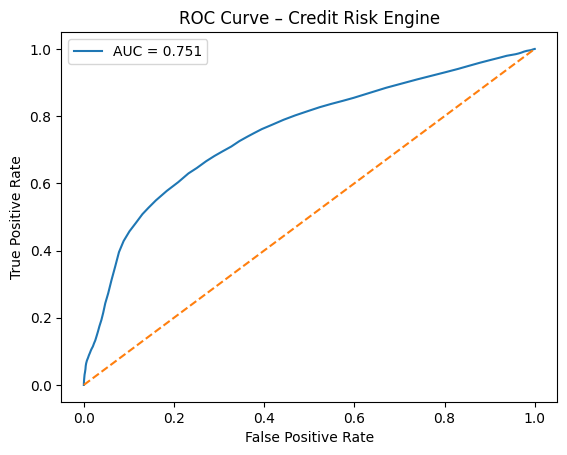

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Risk Engine")
plt.legend()
plt.show()


In [ ]:
# Check default rate by score bucket
pd.qcut(df_inputs["credit_score"], q=5).to_frame("score_bucket") \
    .join(y_true) \
    .groupby("score_bucket")["loan_status"] \
    .mean()


/tmp/ipython-input-4178106618.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("score_bucket")["loan_status"] \


,loan_status
score_bucket,
"(1.999, 38.0]",0.521890
"(38.0, 48.0]",0.221826
"(48.0, 58.0]",0.137752
"(58.0, 63.0]",0.094106
"(63.0, 100.0]",0.088977


In [ ]:
# STEP 5A: Repayment Simulation Function

def simulate_repayment(row, income_factor=1.0, expense_factor=1.0):
    adjusted_income = row["monthly_income"] * income_factor
    adjusted_expenses = row["monthly_expenses"] * expense_factor
    surplus = adjusted_income - adjusted_expenses
    emi = row["expected_emi"]

    emi_stress_ratio = emi / max(surplus, 1)

    if emi_stress_ratio <= 0.5:
        default_risk = "Low"
        warning_month = None
    elif emi_stress_ratio <= 1:
        default_risk = "Medium"
        warning_month = 6
    else:
        default_risk = "High"
        warning_month = 3

    return emi_stress_ratio, default_risk, warning_month


In [ ]:
# STEP 5B: Apply Simulation Scenarios

df_inputs["normal_simulation"] = df_inputs.apply(
    lambda x: simulate_repayment(x, 1.0, 1.0), axis=1
)

df_inputs["income_drop_simulation"] = df_inputs.apply(
    lambda x: simulate_repayment(x, 0.7, 1.0), axis=1
)

df_inputs["expense_shock_simulation"] = df_inputs.apply(
    lambda x: simulate_repayment(x, 1.0, 1.25), axis=1
)


In [ ]:
# STEP 5C: Unpack Simulation Results

def unpack_simulation(col, idx):
    return df_inputs[col].apply(lambda x: x[idx])

df_inputs["normal_default_risk"] = unpack_simulation("normal_simulation", 1)
df_inputs["income_drop_risk"] = unpack_simulation("income_drop_simulation", 1)
df_inputs["expense_shock_risk"] = unpack_simulation("expense_shock_simulation", 1)

df_inputs["warning_month_income_drop"] = unpack_simulation("income_drop_simulation", 2)
df_inputs["warning_month_expense_shock"] = unpack_simulation("expense_shock_simulation", 2)

df_inputs[[
    "decision",
    "normal_default_risk",
    "income_drop_risk",
    "expense_shock_risk",
    "warning_month_income_drop"
]].tail(5)


,decision,normal_default_risk,income_drop_risk,expense_shock_risk,warning_month_income_drop
32576,Approve,Low,Low,Low,NaN
32577,Approve,Low,Low,Low,NaN
32578,Reject,Medium,High,High,3.0
32579,Approve,Low,Low,Low,NaN
32580,Approve,Low,Low,Low,NaN


In [ ]:
approved_ids = df_inputs[df_inputs["decision"] == "Approve"].index.tolist()
review_ids   = df_inputs[df_inputs["decision"] == "Review"].index.tolist()
rejected_ids = df_inputs[df_inputs["decision"] == "Reject"].index.tolist()

print("Approved users:", approved_ids)
print("Review users:", review_ids)
print("Rejected users:", rejected_ids)


Approved users: [17833, 17857, 18635, 23429, 27884, 29119, 29120, 29121, 29122, 29126, 29132, 29133, 29135, 29136, 29137, 29138, 29139, 29142, 29144, 29148, 29151, 29152, 29153, 29154, 29155, 29159, 29160, 29161, 29162, 29163, 29165, 29168, 29171, 29172, 29173, 29174, 29175, 29177, 29178, 29180, 29182, 29183, 29184, 29185, 29188, 29190, 29192, 29195, 29196, 29198, 29200, 29202, 29203, 29204, 29205, 29210, 29214, 29221, 29229, 29231, 29239, 29248, 29274, 29321, 29327, 29342, 29345, 29355, 29356, 29360, 29383, 29408, 29415, 29416, 29418, 29419, 29420, 29424, 29425, 29426, 29431, 29432, 29434, 29435, 29438, 29442, 29444, 29446, 29449, 29450, 29453, 29454, 29456, 29457, 29458, 29459, 29462, 29463, 29464, 29465, 29466, 29468, 29470, 29472, 29473, 29474, 29475, 29478, 29479, 29480, 29481, 29483, 29485, 29486, 29492, 29497, 29498, 29499, 29500, 29503, 29505, 29511, 29513, 29514, 29518, 29519, 29520, 29522, 29523, 29524, 29526, 29529, 29533, 29534, 29536, 29538, 29545, 29546, 29548, 29549, 295

In [ ]:
df["loan_status"].value_counts()


,count
loan_status,
0,25473
1,7108


**ML validation using loan_status**

In [ ]:
# STEP 6A FIXED: Better default mapping

good_status = ["Fully Paid", "Current", "In Grace Period"]
bad_status  = ["Charged Off", "Late (31-120 days)", "Default"]

df_inputs["target_default"] = df["loan_status"].apply(
    lambda x: 0 if x in good_status else 1
)

df_inputs["target_default"].value_counts(normalize=True)



,proportion
target_default,
1,1.0


In [ ]:
# STEP 6A: Target Variable (Correct)

df_inputs["target_default"] = df["loan_status"].astype(int)

df_inputs["target_default"].value_counts(normalize=True)


,proportion
target_default,
0,0.781836
1,0.218164


In [ ]:
df["loan_status"].value_counts()


,count
loan_status,
0,25473
1,7108


In [ ]:
assert df_inputs["target_default"].nunique() == 2, "Target must have 2 classes"


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [ ]:
# FORCE correct target
df_inputs["target_default"] = df["loan_status"].astype(int)

# Verify distribution
df_inputs["target_default"].value_counts()


,count
target_default,
0,25473
1,7108


In [ ]:
assert df_inputs["target_default"].nunique() == 2, \
       "Target has only one class — cannot train ML"


In [ ]:
ml_features = [
    "income_to_emi",
    "cashflow_surplus",
    "savings_buffer_score",
    "behavior_consistency",
    "repayment_reliability"
]

X = df_inputs[ml_features]
y = df_inputs["target_default"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y   # THIS is critical
)


In [ ]:
y_train.value_counts()
y_test.value_counts()


,count
target_default,
0,6369
1,1777


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # credit data best practice
    solver="lbfgs"
)

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
def validate_binary_target(y):
    assert y.nunique() == 2, "Target must have exactly 2 classes"
    assert y.value_counts().min() > 10, "Too few samples in a class"

validate_binary_target(y_train)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(y_test, model.predict(X_test))
precision = precision_score(y_test, model.predict(X_test))
recall    = recall_score(y_test, model.predict(X_test))
f1        = f1_score(y_test, model.predict(X_test))
auc       = roc_auc_score(y_test, y_prob)

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Default)", "Recall (Default)", "F1-score", "ROC-AUC"],
    "Value": [accuracy, precision, recall, f1, auc]
})

summary_df


,Metric,Value
0,Accuracy,0.717653
1,Precision (Default),0.411804
2,Recall (Default),0.687113
3,F1-score,0.514973
4,ROC-AUC,0.777913


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test,
    model.predict(X_test),
    output_dict=True
)

classwise_df = pd.DataFrame(report).T
classwise_df = classwise_df.loc[["0", "1"]]
classwise_df.rename(index={
    "0": "Non-Default (Good Loan)",
    "1": "Default (Bad Loan)"
}, inplace=True)

classwise_df


,precision,recall,f1-score,support
Non-Default (Good Loan),0.892685,0.726174,0.800866,6369.0
Default (Bad Loan),0.411804,0.687113,0.514973,1777.0


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model.predict(X_test))

cm_df = pd.DataFrame(
    cm,
    index=["Actual: Non-Default", "Actual: Default"],
    columns=["Predicted: Non-Default", "Predicted: Default"]
)

cm_df


,Predicted: Non-Default,Predicted: Default
Actual: Non-Default,4625,1744
Actual: Default,556,1221


In [ ]:
print("====== CREDIT RISK ENGINE VALIDATION ======\n")

print("▶ Executive Metrics")
display(summary_df)

print("\n▶ Class-wise Performance")
display(classwise_df)

print("\n▶ Confusion Matrix")
display(cm_df)

print("\n==========================================")


====== CREDIT RISK ENGINE VALIDATION ======

▶ Executive Metrics


,Metric,Value
0,Accuracy,0.717653
1,Precision (Default),0.411804
2,Recall (Default),0.687113
3,F1-score,0.514973
4,ROC-AUC,0.777913



▶ Class-wise Performance


,precision,recall,f1-score,support
Non-Default (Good Loan),0.892685,0.726174,0.800866,6369.0
Default (Bad Loan),0.411804,0.687113,0.514973,1777.0



▶ Confusion Matrix


,Predicted: Non-Default,Predicted: Default
Actual: Non-Default,4625,1744
Actual: Default,556,1221


**Fairness & bias analysis**

In [ ]:
fairness_age = (
    df_inputs
    .groupby("age_group")["decision"]
    .value_counts(normalize=True)
    .unstack()
)

fairness_age


/tmp/ipython-input-62154321.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")["decision"]


decision,Approve,Reject,Review
age_group,,,
18-25,0.000000,0.490294,0.509706
26-35,0.000363,0.408704,0.590932
36-50,0.327565,0.233166,0.439270
50+,0.522968,0.183746,0.293286


In [ ]:
df_inputs["actual_default"] = df["loan_status"]

default_age = (
    df_inputs
    .groupby("age_group")["actual_default"]
    .mean()
)

default_age


/tmp/ipython-input-1652203365.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")["actual_default"]


,actual_default
age_group,
18-25,0.230263
26-35,0.206786
36-50,0.205790
50+,0.257951


In [ ]:
fairness_age = (
    df_inputs
    .groupby("age_group", observed=False)["decision"]
    .value_counts(normalize=True)
    .unstack()
)


In [ ]:
fairness_employment = (
    df_inputs
    .groupby("employment_type", observed=False)["decision"]
    .value_counts(normalize=True)
    .unstack()
)

fairness_employment


decision,Approve,Reject,Review
employment_type,,,
Salaried,0.040299,0.393658,0.566043
Self-employed,0.014172,0.641940,0.343888


In [ ]:
df_inputs["actual_default"] = df["loan_status"]

default_employment = (
    df_inputs
    .groupby("employment_type", observed=False)["actual_default"]
    .mean()
)

default_employment


,actual_default
employment_type,
Salaried,0.180011
Self-employed,0.455270


In [ ]:
employment_fairness_summary = pd.concat(
    [fairness_employment, default_employment.rename("Actual Default Rate")],
    axis=1
)

employment_fairness_summary


,Approve,Reject,Review,Actual Default Rate
employment_type,,,,
Salaried,0.040299,0.393658,0.566043,0.180011
Self-employed,0.014172,0.641940,0.343888,0.455270


In [ ]:
def approval_rate(df, group_col):
    return (
        df[df["decision"] == "Approve"]
        .groupby(group_col)
        .size()
        / df.groupby(group_col).size()
    )

approval_rates = approval_rate(df_inputs, "employment_type")
approval_rates


,0
employment_type,
Salaried,0.040299
Self-employed,0.014172


In [ ]:
di_ratio = approval_rates / approval_rates.loc["Salaried"]
di_ratio


,0
employment_type,
Salaried,1.000000
Self-employed,0.351664


In [ ]:
review_share = (
    df_inputs[df_inputs["decision"] == "Review"]
    .groupby("employment_type")
    .size()
    / df_inputs.groupby("employment_type").size()
)

review_share


,0
employment_type,
Salaried,0.566043
Self-employed,0.343888


In [ ]:
fairness_city = (
    df_inputs
    .groupby("city_tier", observed=False)["decision"]
    .value_counts(normalize=True)
    .unstack()
)

fairness_city


decision,Approve,Reject,Review
city_tier,,,
Tier 3,0.011945,0.669795,0.318259
Tier 2,0.020604,0.544694,0.434702
Tier 1,0.039603,0.365589,0.594808
Tier 1+,0.082957,0.215118,0.701925


In [ ]:
df_inputs["actual_default"] = df["loan_status"].astype(int)

default_city = (
    df_inputs
    .groupby("city_tier", observed=False)["actual_default"]
    .mean()
)

default_city


,actual_default
city_tier,
Tier 3,0.754266
Tier 2,0.280325
Tier 1,0.154212
Tier 1+,0.095317


In [ ]:
city_fairness_summary = pd.concat(
    [fairness_city, default_city.rename("Actual Default Rate")],
    axis=1
)

city_fairness_summary


,Approve,Reject,Review,Actual Default Rate
city_tier,,,,
Tier 3,0.011945,0.669795,0.318259,0.754266
Tier 2,0.020604,0.544694,0.434702,0.280325
Tier 1,0.039603,0.365589,0.594808,0.154212
Tier 1+,0.082957,0.215118,0.701925,0.095317


In [ ]:
def approval_rate(df, group_col):
    return (
        df[df["decision"] == "Approve"]
        .groupby(group_col)
        .size()
        / df.groupby(group_col).size()
    )

approval_rates_city = approval_rate(df_inputs, "city_tier")
approval_rates_city


/tmp/ipython-input-3302121112.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_col)
/tmp/ipython-input-3302121112.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / df.groupby(group_col).size()


,0
city_tier,
Tier 3,0.011945
Tier 2,0.020604
Tier 1,0.039603
Tier 1+,0.082957


In [ ]:
di_city = approval_rates_city / approval_rates_city.loc["Tier 1"]
di_city


,0
city_tier,
Tier 3,0.301632
Tier 2,0.520274
Tier 1,1.000000
Tier 1+,2.094737


In [ ]:
review_share_city = (
    df_inputs[df_inputs["decision"] == "Review"]
    .groupby("city_tier")
    .size()
    / df_inputs.groupby("city_tier").size()
)

review_share_city


/tmp/ipython-input-3349177472.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("city_tier")
/tmp/ipython-input-3349177472.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / df_inputs.groupby("city_tier").size()


,0
city_tier,
Tier 3,0.318259
Tier 2,0.434702
Tier 1,0.594808
Tier 1+,0.701925


In [ ]:
fairness_purpose = (
    df_inputs
    .groupby("loan_purpose", observed=False)["decision"]
    .value_counts(normalize=True)
    .unstack()
)

fairness_purpose


decision,Approve,Reject,Review
loan_purpose,,,
DEBTCONSOLIDATION,0.032809,0.433039,0.534152
EDUCATION,0.027119,0.439176,0.533705
HOMEIMPROVEMENT,0.045770,0.409431,0.544799
MEDICAL,0.033108,0.436996,0.529896
PERSONAL,0.048180,0.413512,0.538308
VENTURE,0.037944,0.427347,0.534709


In [ ]:
df_inputs["actual_default"] = df["loan_status"].astype(int)

default_purpose = (
    df_inputs
    .groupby("loan_purpose", observed=False)["actual_default"]
    .mean()
)

default_purpose


,actual_default
loan_purpose,
DEBTCONSOLIDATION,0.285879
EDUCATION,0.172168
HOMEIMPROVEMENT,0.261026
MEDICAL,0.267007
PERSONAL,0.198877
VENTURE,0.148103


In [ ]:
purpose_fairness_summary = pd.concat(
    [fairness_purpose, default_purpose.rename("Actual Default Rate")],
    axis=1
)

purpose_fairness_summary


,Approve,Reject,Review,Actual Default Rate
loan_purpose,,,,
DEBTCONSOLIDATION,0.032809,0.433039,0.534152,0.285879
EDUCATION,0.027119,0.439176,0.533705,0.172168
HOMEIMPROVEMENT,0.045770,0.409431,0.544799,0.261026
MEDICAL,0.033108,0.436996,0.529896,0.267007
PERSONAL,0.048180,0.413512,0.538308,0.198877
VENTURE,0.037944,0.427347,0.534709,0.148103


In [ ]:
def approval_rate(df, group_col):
    return (
        df[df["decision"] == "Approve"]
        .groupby(group_col)
        .size()
        / df.groupby(group_col).size()
    )

approval_rates_purpose = approval_rate(df_inputs, "loan_purpose")
approval_rates_purpose


,0
loan_purpose,
DEBTCONSOLIDATION,0.032809
EDUCATION,0.027119
HOMEIMPROVEMENT,0.045770
MEDICAL,0.033108
PERSONAL,0.048180
VENTURE,0.037944


In [ ]:
reference = "EDUCATION"  # change if needed
di_purpose = approval_rates_purpose / approval_rates_purpose.loc[reference]
di_purpose


,0
loan_purpose,
DEBTCONSOLIDATION,1.209805
EDUCATION,1.000000
HOMEIMPROVEMENT,1.687727
MEDICAL,1.220842
PERSONAL,1.776591
VENTURE,1.399147


In [ ]:
review_share_purpose = (
    df_inputs[df_inputs["decision"] == "Review"]
    .groupby("loan_purpose")
    .size()
    / df_inputs.groupby("loan_purpose").size()
)

review_share_purpose


,0
loan_purpose,
DEBTCONSOLIDATION,0.534152
EDUCATION,0.533705
HOMEIMPROVEMENT,0.544799
MEDICAL,0.529896
PERSONAL,0.538308
VENTURE,0.534709


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/credit_risk_dataset.csv")

features = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length"
]

target = "loan_status"

df = df[features + [target]].dropna()
df.head()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,22,59000,123.0,35000,16.02,0.59,3,1
1,21,9600,5.0,1000,11.14,0.10,2,0
2,25,9600,1.0,5500,12.87,0.57,3,1
3,23,65500,4.0,35000,15.23,0.53,2,1
4,24,54400,8.0,35000,14.27,0.55,4,1


In [ ]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

y_pred = model.predict(X_test_scaled)

print("Model Performance")
print("-----------------")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall   : {recall_score(y_test, y_pred):.2f}")
print(f"F1-score : {f1_score(y_test, y_pred):.2f}")


Model Performance
-----------------
Accuracy : 0.83
Precision: 0.70
Recall   : 0.40
F1-score : 0.51


In [ ]:
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(
    cm,
    index=["Actual Good", "Actual Default"],
    columns=["Predicted Good", "Predicted Default"]
)


,Predicted Good,Predicted Default
Actual Good,5338,271
Actual Default,933,618


In [ ]:
X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)


LogisticRegression(max_iter=1000)

In [ ]:
def predict_person(person_id):
    row = df.iloc[person_id][features]
    scaled = scaler.transform([row])

    risk = model.predict_proba(scaled)[0][1]  # probability of default
    decision = "REJECTED" if risk > 0.5 else "APPROVED"

    return risk, decision


In [ ]:
def predict_person(person_id):
    row = df.iloc[[person_id]][features]  # KEEP AS DATAFRAME
    scaled = scaler.transform(row)

    risk = model.predict_proba(scaled)[0][1]
    decision = "REJECTED" if risk > 0.5 else "APPROVED"

    return risk, decision


In [ ]:
predict_person(10)


(np.float64(0.19015767930037974), 'APPROVED')

In [ ]:
feature_weights = dict(zip(features, model.coef_[0]))


In [ ]:
def feature_contributions(person_id):
    row = df.iloc[person_id][features]
    row_df = pd.DataFrame([row], columns=features)

    scaled = scaler.transform(row_df).iloc[0] if hasattr(scaler.transform(row_df), "iloc") else scaler.transform(row_df)[0]

    contributions = {}
    for i, feature in enumerate(features):
        contributions[feature] = scaled[i] * model.coef_[0][i]

    return dict(
        sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True)
    )



In [ ]:
def why_rejected(person_id):
    contributions = feature_contributions(person_id)

    top_factors = [
        FEATURE_LABELS.get(f, f.replace("_", " "))
        for f, v in contributions.items()
        if v > 0
    ][:3]

    if not top_factors:
        return f"Person {person_id} was rejected due to overall high financial risk."

    explanation = (
        f"Person {person_id} was rejected mainly due to "
        + ", ".join(top_factors)
        + ". These factors increase the likelihood of repayment stress."
    )

    return explanation



In [ ]:
def explain_factor_context(person_id, factor):
    row = df.iloc[person_id]

    if factor == "loan_percent_income":
        return (
            f"For this applicant, the loan repayment consumes "
            f"{round(row['loan_percent_income'] * 100, 1)}% of their income, "
            "which is considered high risk."
        )

    if factor == "person_income":
        return "The applicant's income level is insufficient relative to the requested loan."

    if factor == "person_emp_length":
        return "The applicant has limited employment stability."

    return "This factor negatively impacts repayment capacity."


In [ ]:
def why_rejected(person_id):
    contributions = feature_contributions(person_id)

    risky_factors = [(f, v) for f, v in contributions.items() if v > 0][:2]
    factor_names = [f for f, _ in risky_factors]

    explanation = (
        f"Person {person_id} was rejected mainly due to "
        + ", ".join(FEATURE_LABELS.get(f, f) for f in factor_names)
        + ". "
    )

    explanation += explain_factor_context(person_id, factor_names[0])

    return explanation


In [ ]:
def why_feature(person_id, feature_name):
    contributions = feature_contributions(person_id)

    impact = contributions.get(feature_name)
    if impact is None:
        return "This feature is not used in the model."

    if impact > 0:
        return f"{feature_name.replace('_',' ')} increased the default risk."
    else:
        return f"{feature_name.replace('_',' ')} reduced the risk, but not enough for approval."


In [ ]:
def biggest_risk_factor(person_id):
    contributions = feature_contributions(person_id)
    return list(contributions.items())[0]


In [ ]:
def improvement_advice(person_id):
    worst_feature, _ = biggest_risk_factor(person_id)

    advice = {
        "person_income": "Increase income stability or apply for a smaller loan.",
        "loan_percent_income": "Reduce loan amount to lower repayment burden.",
        "loan_int_rate": "Seek lower interest rate or shorter tenure.",
        "person_emp_length": "Maintain stable employment for longer duration.",
        "cb_person_cred_hist_length": "Build longer credit history with smaller loans."
    }

    return advice.get(
        worst_feature,
        "Improve overall financial stability."
    )


In [ ]:
def why_approved(person_id):
    contributions = feature_contributions(person_id)

    positive_factors = [
        FEATURE_LABELS.get(f, f.replace("_", " "))
        for f, v in contributions.items()
        if v < 0
    ][:3]

    if not positive_factors:
        return f"Person {person_id} was approved due to overall low financial risk."

    return (
        f"Person {person_id} was approved because of "
        + ", ".join(positive_factors)
        + ", which indicate a strong ability to repay the loan."
    )


In [ ]:
def ask(question: str):
    q = question.lower()

    # Extract person id (number in sentence)
    numbers = [int(s) for s in q.split() if s.isdigit()]
    if not numbers:
        return "Please specify a person ID (e.g., 'why 35 was rejected')."

    person_id = numbers[0]
    risk, decision = predict_person(person_id)

    # WHY REJECTED
    if "why" in q and ("reject" in q or "rejected" in q):
        if decision == "REJECTED":
            return why_rejected(person_id)
        else:
            return f"Person {person_id} was approved, not rejected."

    # WHY APPROVED
    if "why" in q and ("accept" in q or "approved" in q):
        if decision == "APPROVED":
            return why_approved(person_id)
        else:
            return (
                f"Person {person_id} was not approved. "
                "You may ask why they were rejected instead."
            )

    # WHY FEATURE
    if "income" in q:
        return why_feature(person_id, "person_income")

    if "interest" in q:
        return why_feature(person_id, "loan_int_rate")

    if "employment" in q:
        return why_feature(person_id, "person_emp_length")

    # IMPROVEMENT
    if "improve" in q or "do" in q or "next" in q:
        return improvement_advice(person_id)

    # FALLBACK
    return (
        f"Person {person_id} decision: {decision} "
        f"(risk score: {round(risk, 2)}). "
        "You can ask why, what mattered, or how to improve."
    )


In [ ]:
FEATURE_LABELS = {
    "person_age": "appropriate age profile",
    "person_income": "stable income level",
    "person_emp_length": "employment stability",
    "loan_amnt": "reasonable loan amount",
    "loan_int_rate": "favorable interest rate",
    "loan_percent_income": "manageable repayment burden",
    "cb_person_cred_hist_length": "sufficient credit history length"
}


In [ ]:
def classify_all(threshold=0.5):
    approved = []
    rejected = []

    for i in range(len(df)):
        risk, decision = predict_person(i)
        if risk > threshold:
            rejected.append(i)
        else:
            approved.append(i)

    return approved, rejected


In [ ]:
approved_ids, rejected_ids = classify_all()


In [ ]:
print("Approved applicants (first 20):", approved_ids[:50])
print("Rejected applicants (first 20):", rejected_ids[:50])

print(f"Total Approved: {len(approved_ids)}")
print(f"Total Rejected: {len(rejected_ids)}")


Approved applicants (first 20): [0, 1, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 23, 27, 28, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 66, 67]
Rejected applicants (first 20): [2, 3, 4, 11, 13, 17, 22, 24, 25, 26, 29, 36, 37, 38, 39, 49, 59, 65, 68, 70, 71, 72, 78, 80, 94, 95, 100, 102, 103, 104, 105, 106, 111, 114, 115, 116, 117, 118, 119, 126, 127, 128, 129, 130, 132, 135, 136, 137, 138, 139]
Total Approved: 25016
Total Rejected: 3622


In [ ]:
ask("why 35 was accepted")



'Person 35 was approved because of favorable interest rate, appropriate age profile, stable income level, which indicate a strong ability to repay the loan.'

In [ ]:
ask("why 35 was rejected")

'Person 35 was approved, not rejected.'

In [ ]:
ask("why 70 was accepted")

'Person 70 was not approved. You may ask why they were rejected instead.'

In [ ]:
ask("why 70 was rejected")

'Person 70 was rejected mainly due to manageable repayment burden, favorable interest rate. For this applicant, the loan repayment consumes 35.0% of their income, which is considered high risk.'

In [ ]:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
global_importance = pd.Series(model.coef_[0], index=features).sort_values(key=abs, ascending=False)
global_importance


,0
loan_percent_income,1.252074
loan_int_rate,1.023365
loan_amnt,-0.562850
person_emp_length,-0.100059
person_age,0.021642
cb_person_cred_hist_length,-0.015684
person_income,0.012195
